# Train Model

### Notes:

1. considering how much upsampling is going in in each channels for accounting for the perception of each frequency band... I could get away with downsampling the whole thing in the frequency direction by a factor of 4, 8 or even 16, reducing the sample rate post upsample.... this could worth for both the masking model and the diffusion model easily, reducing the image size from (1024, 175) to (128, 175)

2. I need to edit the levels of the training data so that anything where the signal is greater than 1 (due to high noise), should be normalised to 1

Next Steps:

2. Compare custom res-net model with attention as masking with deeplabv3_resnet50 altered. To complete the project, compare:
3. a) Custom simple, b) custom complex, c) deeplabv3_resnet50 d) lraspp_mobilenet_v3_large e) segformer
4. run test and get results
5. Write small extract on findings, and put into markdown on github.

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout bandchannels")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin bandchannels")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
from audioautoencoder.models.UNetConv10mask import *

## Test Model

In [5]:
BATCH_SIZE = 1
t = torch.randint(0, 1000, (BATCH_SIZE,))
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 9, 1025 // 4, 175))
      model = UNetConv10()
      model.eval()
      output = model(x)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 256, 175])


In [6]:
print(model)


UNetConv10(
  (sigmoid): Sigmoid()
  (enc1): Sequential(
    (0): Conv2d(9, 64, kernel_size=(6, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(6, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128

## Define Params

In [7]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv10().to(device)

print(device)

cuda


In [22]:
i = 0
train = True
LOAD_DATA = True
load_model = False

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv10'
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features', 'all-noise_features', 'all-noise_features_2'][2] # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training? # lowered learning rate for
                        # when the loss explodes after the learning rate increases, it means dont increase the learning rate too much
base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 150
IMPORT_TRAIN_NOISY = train
batch_size = 256

# training params
load = load_trigger[i]
warm_start = True
epochs = 100
accumulation_steps = int((512*2)/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [-10, 10]


In [23]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [24]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [25]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [26]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      #combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)
      combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_separation(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size,
          num_workers=12
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'input_features_edges': StandardScaler(), 'input_features_cepstrum': StandardScaler(), 'input_features_cepstrum_edges': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Training set size: 34472
Validation set size: 8619
Training set size: 34472
Validation set size: 8619


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Inspect Data

In [27]:
if LOAD_DATA:
  _, output, medatata = train_loader.train_dataset[200]
  #input, output = train_dataset[0]
  #print(metadata['snr_db'])
  #print(input.shape)
  print(output.shape)

torch.Size([4, 256, 175])


2.7098236083984375
(4, 256, 175)
(256, 175)
Min, Max:  -0.13173898 2.2763112
(256, 175)
Min, Max:  -0.53963554 1.6745008
(256, 175)
Min, Max:  -0.60786366 1.285335
(256, 175)
Min, Max:  -0.28628424 1.2877014
(256, 175)
Min, Max:  -1.0 4.038307
(256, 175)
Min, Max:  -1.0 2.6473742
(256, 175)
Min, Max:  -0.986457 2.2505324
(256, 175)
Min, Max:  -0.99151397 2.2524486
(256, 175)
Min, Max:  -1.0 3.7572541
Min, Max:  -0.41882783 1.4091009
Min, Max:  -0.646108 1.5294168
Min, Max:  -0.7892477 1.2879013
Min, Max:  -0.4566592 1.2903686


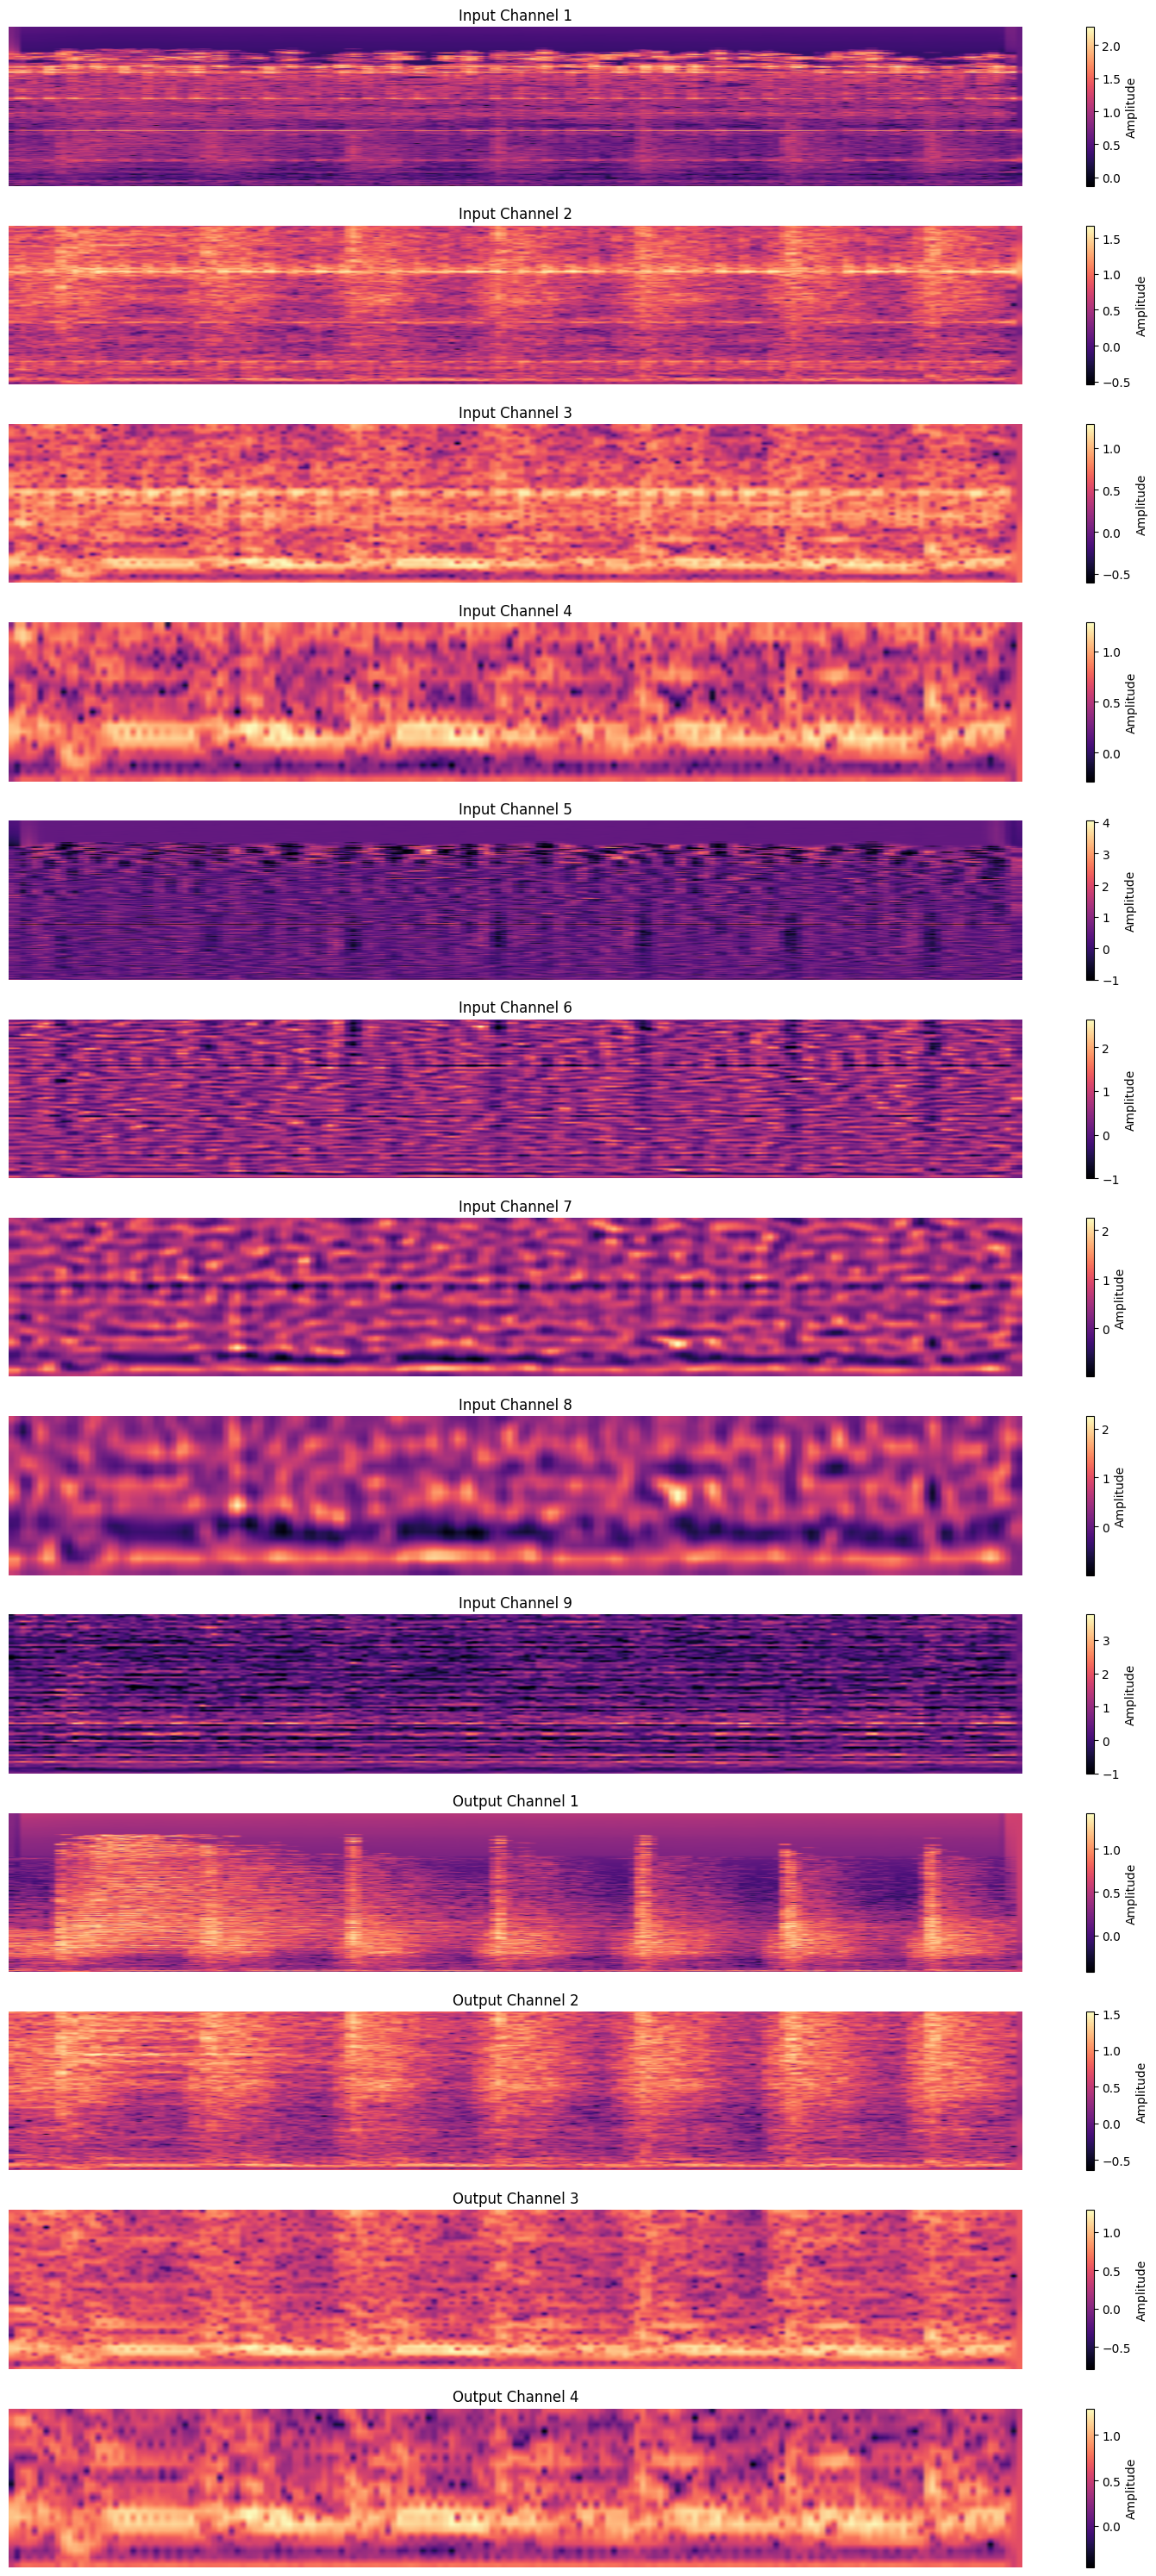

In [28]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample
  input_tensor, output_tensor, metadata = train_loader.train_dataset[51]

  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  #input_array = np.clip(input_tensor.numpy(), -1, a_max=None)
  output_array = np.clip(output_tensor.numpy(), -1, a_max=None)
  input_array = np.clip(input_tensor.numpy(), -1, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0
  print(np.shape(output_array))

  num_channels_out = output_array.shape[0]
  num_channels_in = input_array.shape[0]


  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print(np.shape(input))
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [29]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [30]:
import torch

torch.cuda.empty_cache()

In [31]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [32]:
from audioautoencoder.plotting import *
from audioautoencoder.training import *

In [33]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [34]:
from audioautoencoder.training import *

# plot example inputs



In [35]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.00, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

Training on device: cuda
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/135 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:   1%|          | 1/135 [01:49<4:05:39, 110.00s/batch, loss=loss: 0.2926, ref:0.2839]


KeyboardInterrupt: 

___